	This is a small project I worked on for the Pattern Classification course I took at UTK using a dataset I had generated from my work at Baylor University during my masters.  I revisit this occasionally to experiment with different methods.  The data set includes 166 samples of Late Cretaceous Eagle Ford and Pepper Formations, collected from outcrops in Waco and other locations around McLennan County in central Texas.  A suite of geochemical analyses were performed on each sample including the total organic carbon (TOC), total N, 13Corg, 15N and inorganic major, and trace elements More information about this data set can be found in the original paper [here](https://www.researchgate.net/profile/Kenneth_Boling/publication/273354575_Origin_of_organic_matter_in_the_Eagle_Ford_Formation/links/580a255408aeef1bfee3df79/Origin-of-organic-matter-in-the-Eagle-Ford-Formation.pdf).         

In [48]:
#reset all variables within the Jupyter notebook when ready to rerun
%reset -f

In [49]:
# ECE 571 Pattern Classification
# Final Project
# Ken Boling
# Python 3.6.2
# Pycharm Development Environment

## Import packages ##

# Data handling tools:
import numpy as np
import pandas as pd
import os


# Data visualization tools:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Specific Scikit-Learn libraries:
from sklearn import decomposition, neighbors, tree, metrics, feature_selection
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.model_selection import validation_curve, ShuffleSplit
from sklearn.neural_network import MLPClassifier

# Juypter Notebook tools:
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [50]:
# Formatting for tables to display nicely within the notebook, we'll see if this actually works...
# https://github.com/chris1610/pbpython/blob/master/notebooks/Ipython-pandas-tips-and-tricks.ipynb

CSS = """
body {
    margin: 0;
    font-family: Helvetica;
}
table.dataframe {
    border-collapse: collapse;
    border: none;
}
table.dataframe tr {
    border: none;
}
table.dataframe td, table.dataframe th {
    margin: 0;
    border: 1px solid white;
    padding-left: 0.25em;
    padding-right: 0.25em;
}
table.dataframe th:not(:empty) {
    background-color: #fec;
    text-align: left;
    font-weight: normal;
}
table.dataframe tr:nth-child(2) th:empty {
    border-left: none;
    border-right: 1px dashed #888;
}
table.dataframe td {
    border: 2px solid #ccf;
    background-color: #f4f4ff;
}
"""

In [51]:
# Set working directory
os.chdir('C:\\Users\\Ken\\Google Drive\\UTK Class work\\Pattern Classification\\Final Project\\ECE 571 project final')

HTML('<style>{}</style>'.format(CSS))

<style>
body {
    margin: 0;
    font-family: Helvetica;
}
table.dataframe {
    border-collapse: collapse;
    border: none;
}
table.dataframe tr {
    border: none;
}
table.dataframe td, table.dataframe th {
    margin: 0;
    border: 1px solid white;
    padding-left: 0.25em;
    padding-right: 0.25em;
}
table.dataframe th:not(:empty) {
    background-color: #fec;
    text-align: left;
    font-weight: normal;
}
table.dataframe tr:nth-child(2) th:empty {
    border-left: none;
    border-right: 1px dashed #888;
}
table.dataframe td {
    border: 2px solid #ccf;
    background-color: #f4f4ff;
}
</style>

In [52]:

# import cleaned data

training_cleaned_import = pd.read_csv(
    'C:\\Users\\Ken\\Google Drive\\UTK Class work\\Pattern Classification\\Final Project\\ECE 571 project final\\Cleaned Data\\Eagleford_data_KSB_2015_training_cleaned.csv')

testing_cleaned_import = pd.read_csv(
    'C:\\Users\\Ken\\Google Drive\\UTK Class work\\Pattern Classification\\Final Project\\ECE 571 project final\\Cleaned Data\\Eldrett_French_Geochem_testing_cleaned.csv')


# make a separate df of just the data from French 2019

french_only_import = testing_cleaned_import.loc[testing_cleaned_import['Sample_ID'].str.contains("E151")==True] # ['Sample_ID'].str.startswith('E151')] 
# display(french_only_import.head(5))

# drop columns that are not used for classification

training_cleaned = training_cleaned_import.drop(['Vertical_position_cm','Sample_ID'], axis=1)
testing_cleaned = testing_cleaned_import.drop(columns=testing_cleaned_import[['Depth_m','Sample_ID']])
french_cleaned = french_only_import.drop(columns=french_only_import[['Depth_m','Sample_ID']])

#training_cleaned.astype(np.float64)
#testing_cleaned.astype('float64')
#french_cleaned.astype('float64')
#pd.DataFrame(training_cleaned.head(10))
#HTML(df.to_html())
print('Training Data Sample:')
display(training_cleaned.iloc[:10,:15])
#display(testing_cleaned.info())
#display(french_cleaned.info())

Training Data Sample:


,Al2O3_wt_%,SiO2_wt_%,TiO2_wt_%,Fe2O3_wt_%,MnO_wt_%,MgO_wt_%,CaO_wt_%,K2O_wt_%,P2O5_wt_%,Ba_ppm,Cr_ppm,Sr_ppm,Zn_ppm,Zr_ppm,V_ppm
0,15.2,59.6,0.7,4.7,0.0,1.5,8.4,2.0,0.1,178,55,287,53,257,96
1,14.0,57.8,0.6,4.4,0.1,1.5,13.8,1.7,0.1,143,44,313,44,237,76
2,8.8,46.1,0.3,3.3,0.1,1.4,30.7,0.9,0.2,61,23,362,27,187,35
3,14.2,58.3,0.6,4.7,0.0,1.5,11.6,2.0,0.1,159,53,333,49,216,86
4,17.6,55.7,0.8,5.6,0.1,1.6,3.6,2.1,0.1,226,92,172,73,166,170
5,19.1,56.0,1.0,5.1,0.0,1.2,0.1,2.4,0.1,303,104,97,117,156,189
6,19.0,61.4,1.0,3.9,0.0,0.7,0.1,2.5,0.0,286,96,155,76,158,186
7,19.3,61.1,1.0,4.1,0.0,0.7,0.1,2.4,0.1,289,98,114,70,157,180
8,19.0,60.7,1.0,3.9,0.0,0.7,0.1,2.4,0.1,304,97,185,69,179,186
9,19.5,58.9,1.0,4.2,0.0,0.7,0.1,2.5,0.1,301,96,149,197,171,185


<Figure size 432x288 with 0 Axes>

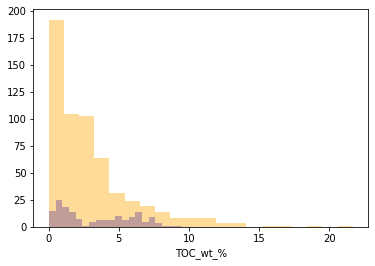

In [53]:
plt.figure()
sns.distplot(training_cleaned['TOC_wt_%'],kde=False, rug =False, color= 'blue',bins=20)
sns.distplot(testing_cleaned['TOC_wt_%'],kde=False, rug =False, color='orange',bins=20)



In [54]:
# preprocessing function

def toc_preprocess(df):
    
    # drop anything below 0.4 wt% toc
    #df = df.drop(df[df['TOC_wt_%'] <= 0.4].index)
    
    # set up categories based on toc wt % 
    conditions = (df['TOC_wt_%'] <= 0.5),\
                 ((df['TOC_wt_%'] > 0.5) & (df['TOC_wt_%']<= 1.0)),\
                 ((df['TOC_wt_%'] > 1.0) & (df['TOC_wt_%']<= 2.0)),\
                 ((df['TOC_wt_%'] > 2.0) & (df['TOC_wt_%']<= 4.0)),\
                 ((df['TOC_wt_%'] > 4.0) & (df['TOC_wt_%']<= 10.0)),\
                 (df['TOC_wt_%']> 10.0)
    
    choices = (['1 very poor','2 poor','3 fair','4 good', '5 very good','6 excellent'])
    
    df['toc_rating'] = np.select(conditions,choices)
    
    df.toc_rating = df.toc_rating.astype('str') #probably not needed
    
    # round to one decimal place
    df.round(decimals=1)
    
    return df
   
    
    # use zscore normalization to center the mean at zero for the training data 
    # then use those same parameters to normalize the testing data

def normalize(training_set, testing_set):
    
    # select only the columns with numerical information
    num_cols_training = training_set.columns[training_set.dtypes.apply(lambda i: np.issubdtype(i, np.number))]
    num_cols_testing = testing_set.columns[testing_set.dtypes.apply(lambda i: np.issubdtype(i, np.number))]


    zscore = StandardScaler()
    zscore.fit(training_set[num_cols_training])
    
    training_set[num_cols_training] = zscore.transform(training_set[num_cols_training])
    testing_set[num_cols_testing] = zscore.transform(testing_set[num_cols_testing])

    # set up outputs\
    norm_train_data = training_set

    norm_testing_data = testing_set

    
    
    return norm_train_data, norm_testing_data


In [55]:
# run the preprocessing function
training_cleaned_preprocessed = toc_preprocess(training_cleaned)
testing_cleaned_preprocessed = toc_preprocess(testing_cleaned)
french_cleaned_preprocessed = toc_preprocess(french_cleaned)


norm_train_data, norm_testing_data = normalize(training_cleaned_preprocessed,testing_cleaned_preprocessed )
french_norm_train_data, french_norm_testing_data = normalize(training_cleaned_preprocessed,french_cleaned_preprocessed)


num_col_training = norm_train_data.columns[norm_train_data.dtypes.apply(lambda i: np.issubdtype(i, np.number))]
num_col_testing = norm_testing_data.columns[norm_testing_data.dtypes.apply(lambda i: np.issubdtype(i, np.number))]
num_col_french = french_norm_testing_data.columns[french_norm_testing_data.dtypes.apply(lambda i: np.issubdtype(i, np.number))]


X_train_data = norm_train_data[num_col_training]
X_test_data = norm_testing_data[num_col_testing]
X_french_data = french_norm_testing_data[num_col_french]


y_train_target_classifier = norm_train_data[['toc_rating']]
y_test_target_classifier = norm_testing_data[['toc_rating']]
y_french_target_classifier = french_norm_testing_data[['toc_rating']]

y_train_target_regression = norm_train_data[['TOC_wt_%']]
y_test_target_regression = norm_testing_data[['TOC_wt_%']]
y_french_target_regression = french_norm_testing_data[['TOC_wt_%']]

#X_test_data , y_test_target, y_test_reg, test_fulldf = toc_preprocess(testing_cleaned)

#X_french_data , y_french_target, y_french_reg, french_fulldf = toc_preprocess(french_cleaned)


Text(0.5, 1.05, 'pair_plot_training_set')

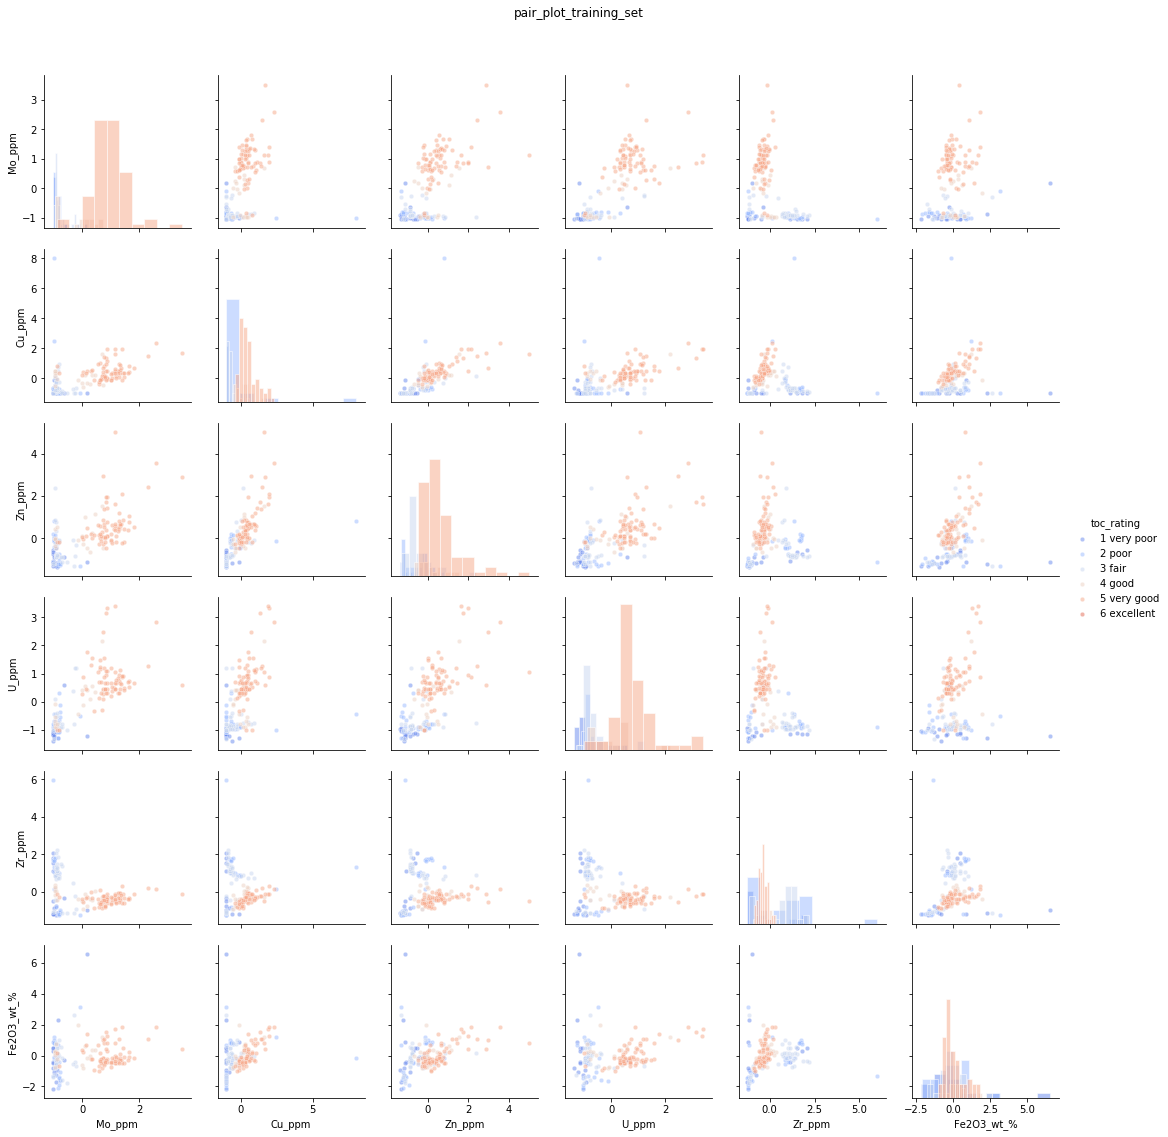

Text(0.5, 1.05, 'pair_plot_testing_set')

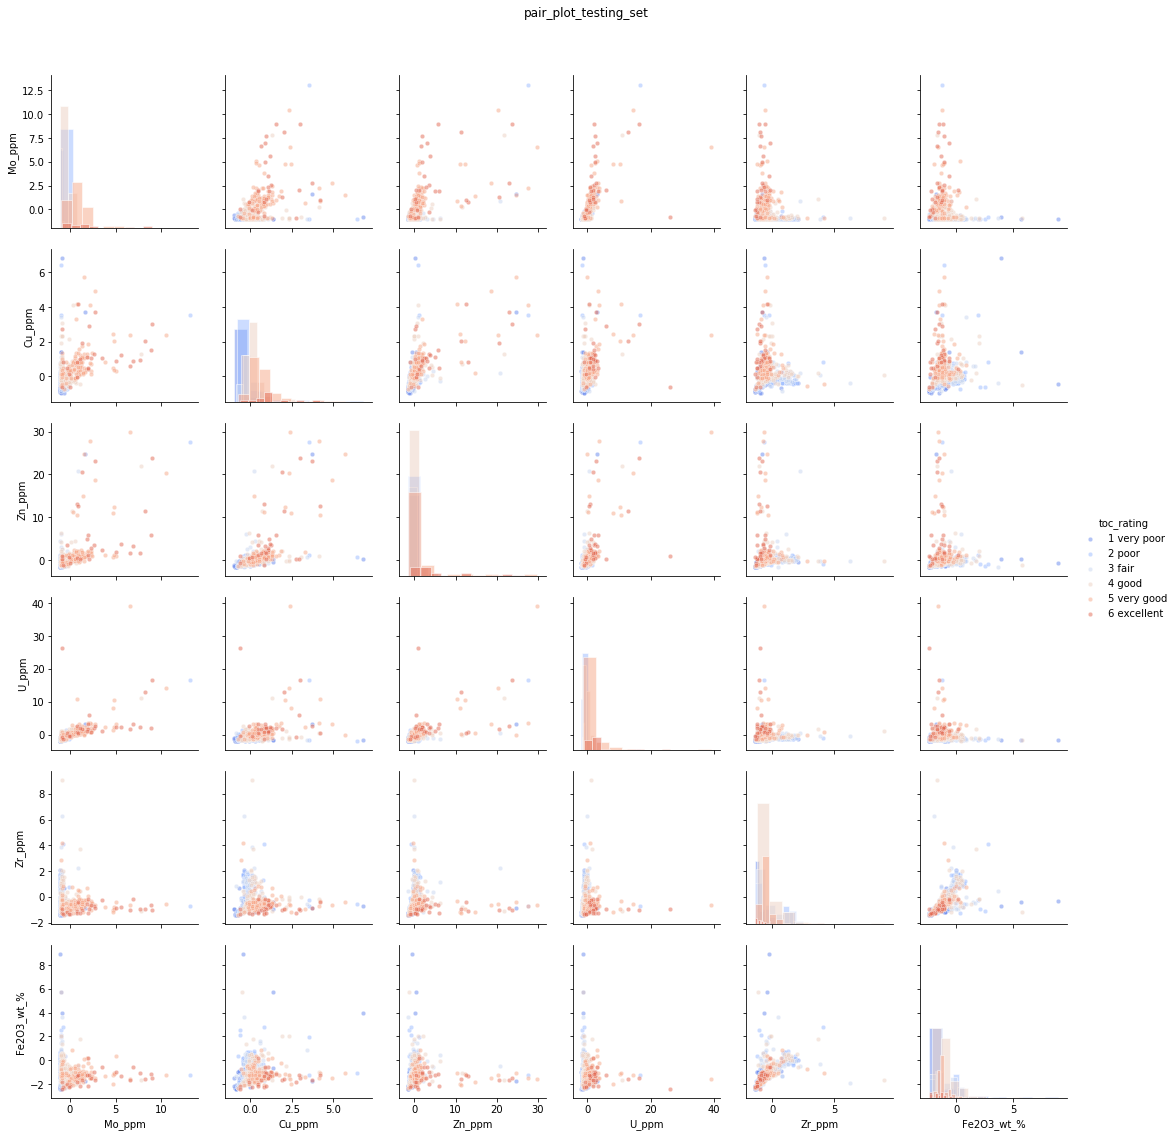

In [56]:
# make pairplots

pairplot_training = sns.PairGrid(data=training_cleaned_preprocessed,
                                 vars=training_cleaned_preprocessed[['Mo_ppm','Cu_ppm','Zn_ppm','U_ppm','Zr_ppm', 'Fe2O3_wt_%']],
                                 hue = 'toc_rating',
                                 hue_order=['1 very poor','2 poor','3 fair','4 good', '5 very good','6 excellent'],
                                 palette=sns.color_palette("coolwarm",6))

pairplot_training.map_diag(plt.hist, edgecolor="w", alpha=0.5)
pairplot_training.map_offdiag(plt.scatter, edgecolor="w", linewidths=.5, s=20, alpha=0.5)
pairplot_training.add_legend()
pairplot_training.fig.suptitle('pair_plot_training_set', x=0.5, y=1.05)  # add a title above the plots
pairplot_training.savefig('Final_project_pair_plot_training_set', dpi=300)

plt.show(pairplot_training)



pairplot_testing = sns.PairGrid(data=testing_cleaned_preprocessed,
                                vars=testing_cleaned_preprocessed[['Mo_ppm','Cu_ppm','Zn_ppm','U_ppm','Zr_ppm', 'Fe2O3_wt_%']],
                                hue = 'toc_rating',
                                hue_order=['1 very poor','2 poor','3 fair','4 good', '5 very good','6 excellent'],
                                palette=sns.color_palette("coolwarm",6))

pairplot_testing.map_diag(plt.hist, edgecolor="w", alpha=0.5)
pairplot_testing.map_offdiag(plt.scatter, edgecolor="w", linewidths=.5, s=20, alpha=0.5)
pairplot_testing.add_legend()
pairplot_testing.fig.suptitle('pair_plot_testing_set', x=0.5, y=1.05)  # add a title above the plots
pairplot_testing.savefig('Final_project_pair_plot_testing_set', dpi=300)

plt.show(pairplot_testing)


In [57]:


#apply SelectKBest class to extract top 10 best features
#bestfeatures = feature_selection.SelectKBest(score_func=feature_selection.chi2, k=10)
#best = bestfeatures.fit(X_train_data,y_train_reg)

#dfscores = pd.DataFrame(best.scores_)
#dfcolumns = pd.DataFrame(X_train_data.columns)
#concat two dataframes for better visualization 
#featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#featureScores.columns = ['Specs','Score']  #naming the dataframe columns
#print(featureScores.nlargest(10,'Score'))  #print 10 best features

In [58]:

trace_training = X_train_data[['Ba_ppm','Cr_ppm','Sr_ppm','Zn_ppm','Zr_ppm','V_ppm','Co_ppm','Ni_ppm','Cu_ppm','Rb_ppm','Y_ppm','Nb_ppm','Mo_ppm','Pb_ppm','Th_ppm','U_ppm']]
trace_testing = X_test_data[['Ba_ppm','Cr_ppm','Sr_ppm','Zn_ppm','Zr_ppm','V_ppm','Co_ppm','Ni_ppm','Cu_ppm','Rb_ppm','Y_ppm','Nb_ppm','Mo_ppm','Pb_ppm','Th_ppm','U_ppm']]

major_training = X_train_data[['Al2O3_wt_%','SiO2_wt_%',	'TiO2_wt_%',	'Fe2O3_wt_%',	'MnO_wt_%',	'MgO_wt_%',	'CaO_wt_%',	'K2O_wt_%',	'P2O5_wt_%']]
major_testing = X_test_data[['Al2O3_wt_%','SiO2_wt_%','TiO2_wt_%',	'Fe2O3_wt_%',	'MnO_wt_%',	'MgO_wt_%',	'CaO_wt_%',	'K2O_wt_%',	'P2O5_wt_%']]

In [59]:

# PCA FUNCTION
def pca_func(df, n_components):
    pca = decomposition.PCA(n_components=n_components)
    num_cols = df.columns[df.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
    pca.fit(df[num_cols])
    df_transformed_pca = pd.DataFrame(data=pca.transform(df[num_cols]))
    print('explained variance values:',pca.explained_variance_ratio_  )
    return df_transformed_pca

In [60]:
%matplotlib inline

order = ['1 very poor','2 poor','3 fair','4 good', '5 very good','6 excellent']

# creates a new series of numbers instead of strings using a dictionary
color_dict = {'1 very poor': 1,'2 poor':2,'3 fair':3,'4 good':4, '5 very good':5,'6 excellent':6}


y_train_target_colors = y_train_target_classifier.replace(color_dict)



In [61]:

# run PCA 
training_pca_transformed = pca_func(X_train_data, n_components=8)
testing_pca_transformed = pca_func(X_test_data, n_components=8)
french_pca_transformed = pca_func(X_french_data, n_components=8)


trace_training_pca_transformed = pca_func(trace_training, n_components=8)
major_traing_pca_transformed = pca_func(major_training, n_components=8)

trace_testing_pca_transformed = pca_func(trace_testing, n_components=8)
major_testing_pca_transformed = pca_func(major_testing, n_components=8)



explained variance values: [0.47932948 0.21666472 0.05934725 0.05507271 0.03633101 0.03011126
 0.02589405 0.0190076 ]
explained variance values: [0.44512618 0.19908307 0.10704639 0.05721478 0.04559768 0.03148333
 0.02438183 0.0170088 ]
explained variance values: [0.50133438 0.31103451 0.1058871  0.05392182 0.01340995 0.00709602
 0.00325226 0.00149422]
explained variance values: [0.46690107 0.28610189 0.05676056 0.04078909 0.03665263 0.0280028
 0.02184413 0.01473696]
explained variance values: [0.56734903 0.15889452 0.11118388 0.10615302 0.03545668 0.00862431
 0.00741517 0.00398389]
explained variance values: [0.54030824 0.14617589 0.09660102 0.06627558 0.0408622  0.03182962
 0.0277241  0.01546572]
explained variance values: [0.719767   0.14645372 0.07026914 0.03590233 0.01312625 0.00674792
 0.00377856 0.00293849]


In [62]:
def triple_plot(df,c):
    ax1 = Axes3D(plt.figure())
    ax1.plot(df.iloc[:,0], df.iloc[:,1], df.iloc[:,2], c=c, marker='o',cmap=plt.get_cmap('hot'))
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.set_zlabel('Principal Component 3')
    plt.show()

#triple_plot(df=training_pca_transformed,
 #           c=y_train_target_colors[['toc_rating']])


# pairplot_testing.fig.suptitle('pair_plot_testing_set', x=0.5, y=1.05)  # add a title above the plots



In [63]:
def pca_2d_plot(x,y,title):
    plt.figure()
    plt.grid()
   
    plt.title(title)
    sns.scatterplot(
        x=x, 
        y=y,
        hue = y_train_target_classifier['toc_rating'],
        hue_order=['1 very poor','2 poor','3 fair','4 good', '5 very good','6 excellent'],
        palette=sns.color_palette("coolwarm"),
        linewidth=.1,
        alpha=0.9)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(bbox_to_anchor=(1.05, 0.8), title='TOC Rating')
    plt.tight_layout()

    plt.savefig(title, dpi=600)


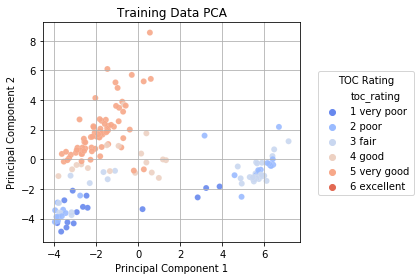

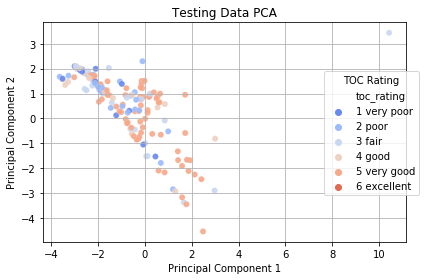

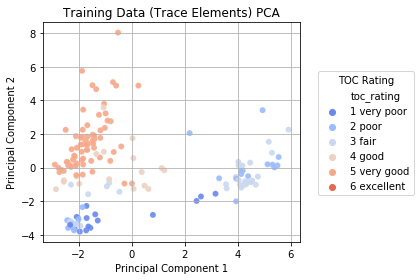

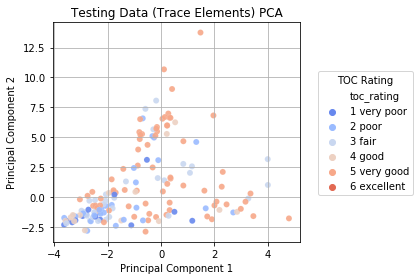

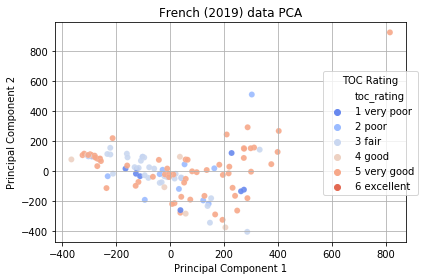

In [64]:
pca_2d_plot(x=training_pca_transformed.iloc[:,0], y=training_pca_transformed.iloc[:,1],title='Training Data PCA')
pca_2d_plot(x=testing_pca_transformed.iloc[:,0], y=testing_pca_transformed.iloc[:,1],title='Testing Data PCA')

pca_2d_plot(x=trace_training_pca_transformed.iloc[:,0], y=trace_training_pca_transformed.iloc[:,1],title='Training Data (Trace Elements) PCA')
pca_2d_plot(x=trace_testing_pca_transformed.iloc[:,0], y=trace_testing_pca_transformed.iloc[:,1],title='Testing Data (Trace Elements) PCA')

pca_2d_plot(x=french_pca_transformed.iloc[:,0], y=french_pca_transformed.iloc[:,1],title='French (2019) data PCA')


In [65]:
# t-SNE function
from sklearn import manifold

def tsne(df,n_components,perplexity):
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity,n_iter=3000,learning_rate =200)
    num_cols = df.columns[df.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

    df_transformed_tsne = pd.DataFrame(data=tsne.fit_transform(df[num_cols]))
    print('number of iterations: ' + str(tsne.n_iter_ ))
    return df_transformed_tsne
 

number of iterations: 999


number of iterations: 1049


number of iterations: 1299
AxesSubplot(0.125,0.125;0.775x0.755)


<Figure size 432x288 with 0 Axes>

AxesSubplot(0.125,0.125;0.775x0.755)


<Figure size 432x288 with 0 Axes>

AxesSubplot(0.125,0.125;0.775x0.755)


<Figure size 432x288 with 0 Axes>

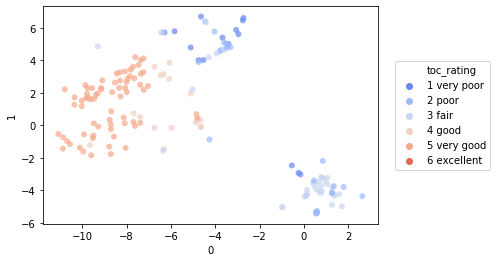

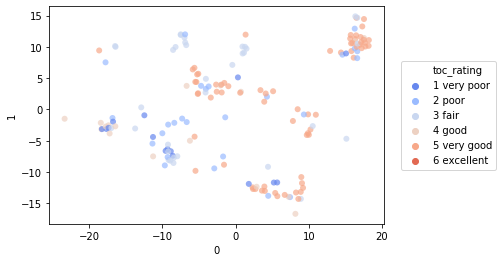

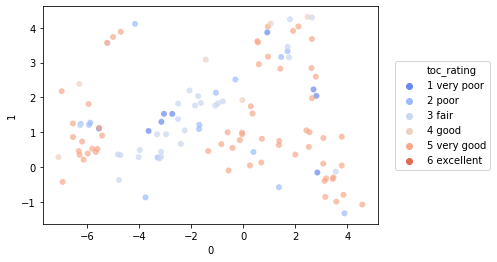

<Figure size 432x288 with 0 Axes>

In [79]:

training_tsne_transformed = tsne(X_train_data,n_components=2,perplexity=45)
testing_tsne_transformed = tsne(X_test_data,n_components=2,perplexity=45)
french_tsne_transformed = tsne(X_french_data,n_components=2,perplexity=45)


fig1 = sns.scatterplot(x=training_tsne_transformed.iloc[:,0], y=training_tsne_transformed.iloc[:,1],
                hue = y_train_target_classifier['toc_rating'],
                hue_order=['1 very poor','2 poor','3 fair','4 good', '5 very good','6 excellent'],
                palette=sns.color_palette("coolwarm"),
                sizes=(1, 8), linewidth=0,  alpha=0.7)
print(fig1)
plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.5), ncol=1)
plt.savefig('tsne_training', dpi=600)
plt.figure()


fig2 = sns.scatterplot(x=testing_tsne_transformed.iloc[:,0], y=testing_tsne_transformed.iloc[:,1],
                hue = y_train_target_classifier['toc_rating'],
                hue_order=['1 very poor','2 poor','3 fair','4 good', '5 very good','6 excellent'],
                palette=sns.color_palette("coolwarm"),
                sizes=(1, 8), linewidth=0,  alpha=0.7)

print(fig2)
plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.5), ncol=1)
plt.savefig('tsne_testing', dpi=600)
plt.figure()


fig3 = sns.scatterplot(x=french_tsne_transformed.iloc[:,0], y=french_tsne_transformed.iloc[:,1],
                hue = y_train_target_classifier['toc_rating'],
                hue_order=['1 very poor','2 poor','3 fair','4 good', '5 very good','6 excellent'],
                palette=sns.color_palette("coolwarm"),
                sizes=(1, 8), linewidth=0,  alpha=0.7)

print(fig3)
plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.5), ncol=1)
plt.savefig('tsne_french', dpi=600)
plt.figure()

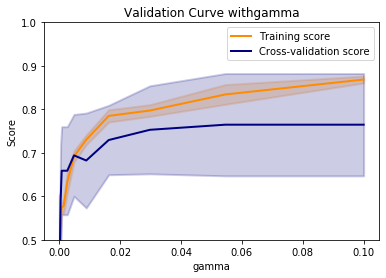

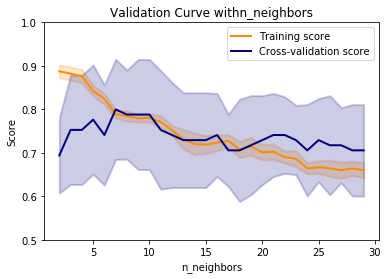

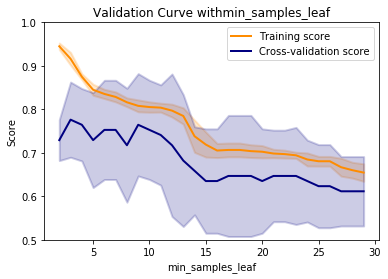

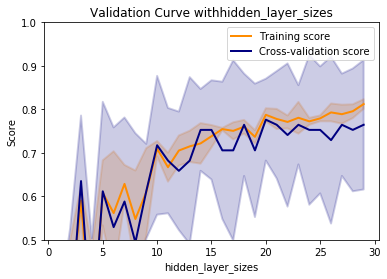

In [82]:
from sklearn import neighbors, tree
from sklearn.svm import SVC, SVR
from sklearn.model_selection import validation_curve
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ShuffleSplit

import warnings
warnings.filterwarnings('ignore', 'Solver terminated early.*')

def validation_plots(X,y, param_range, estimator, param_name ):
    #random_state=1
    cv=ShuffleSplit(n_splits=5, test_size=0.1)

    train_scores, test_scores = \
    validation_curve(estimator=estimator, 
                         X=X, 
                         y=np.ravel(y), 
                         param_name=param_name, 
                         param_range=param_range,
                         cv=cv, 
                         scoring="accuracy", 
                         n_jobs=-1) #n_jobs=-1 uses all processors nice!
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with"+ param_name)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.5, 1.0)
    
    lw = 2
    
    plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
    plt.legend(loc="best")
    plt.savefig(param_name, dpi=600)

    plt.show()
    

def many_plots(data):
    validation_plots(X= data,y=y_train_target_classifier,param_range=np.logspace(-6, -1, 20),estimator=SVC(), param_name="gamma")

    validation_plots(X= data,y=y_train_target_classifier,param_range=np.arange(2, 30, 1),estimator=neighbors.KNeighborsClassifier(), param_name='n_neighbors')

    validation_plots(X= data,y=y_train_target_classifier,param_range=np.arange(2, 30, 1),estimator=tree.DecisionTreeClassifier(), param_name='min_samples_leaf')

        #clf_MLP = MLPClassifier(), max_iter=3000, shuffle=False)
        
    validation_plots(X= data,y=y_train_target_classifier,param_range=np.arange(1, 30, 1),estimator=MLPClassifier(), param_name='hidden_layer_sizes')

    #validation_plots(X= data,y=y_train_target,param_range=np.arange(start=500, stop=2000, step=100),estimator=MLPClassifier(), param_name='max_iter')


#validation_plots(X= X_train_data,y=y_train_reg,param_range=np.arange(1, 30, 1),estimator=tree.DecisionTreeRegressor(), param_name='max_depth')
many_plots(data=training_pca_transformed)



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.04, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

0.12585034013605442


C:\Program Files\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

2.0680882317648583


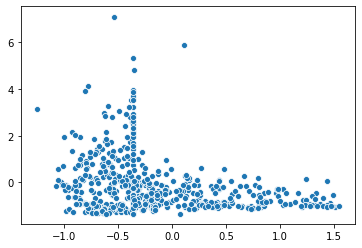

In [83]:
from sklearn import metrics
from sklearn.svm import SVC, SVR

SVM_toc = SVC(gamma=0.04)
SVM_toc.fit(trace_training_pca_transformed, np.ravel(y_train_target_classifier))

guess_SVM = SVM_toc.predict(trace_testing_pca_transformed)

accuracy_SVM = y_test_target_classifier[y_test_target_classifier['toc_rating'] == guess_SVM]
print(accuracy_SVM.shape[0]/y_test_target_classifier.shape[0])

# lets try regression

SVR_toc = SVR(kernel='rbf')

SVR_toc.fit(trace_training_pca_transformed, np.ravel(y_train_target_regression))

guess_SVR = SVR_toc.predict(trace_testing_pca_transformed)

error = metrics.mean_squared_error(np.ravel(y_test_target_regression), guess_SVR)
print(error)
sns.scatterplot(x=guess_SVR ,y=np.ravel(y_test_target_regression))



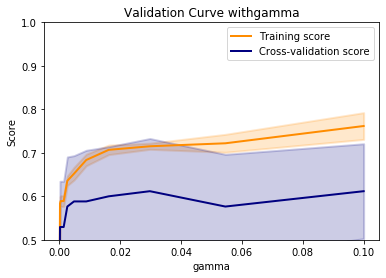

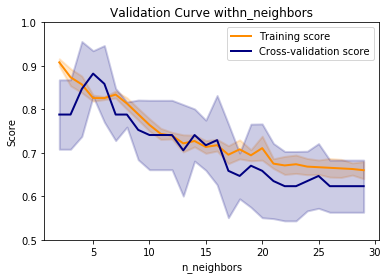

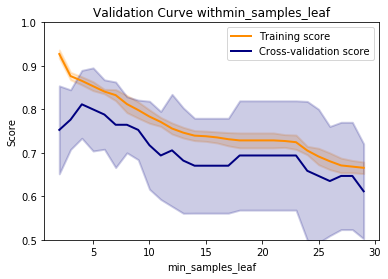

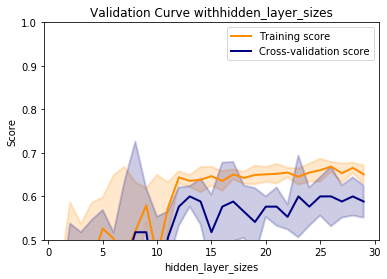

In [84]:

#validation_plots(X= X_train_data,y=y_train_reg,param_range=np.arange(1, 30, 1),estimator=tree.DecisionTreeRegressor(), param_name='max_depth')
many_plots(data=training_tsne_transformed)

In [70]:
from sklearn import metrics

SVM_toc = SVC(gamma=.06)
SVM_toc.fit(X=training_pca_transformed, y=np.ravel(y_train_target))

guess_SVM = SVM_toc.predict(testing_pca_transformed)

accuracy_SVM = y_test_target[y_test_target['toc_rating'] == guess_SVM]
print('SVM accuracy' + str(accuracy_SVM.shape[0]/y_test_target.shape[0]))


kNN_toc = neighbors.KNeighborsClassifier(n_neighbors=5)
kNN_toc.fit(training_pca_transformed, np.ravel(y_train_target))

guess_kNN = kNN_toc.predict(testing_pca_transformed)

accuracy_kNN = y_test_target[y_test_target['toc_rating'] == guess_kNN]
print(accuracy_kNN.shape[0] / y_test_target.shape[0])


# lets try regression

SVR_toc = SVR(kernel='rbf',gamma=0.06)

SVR_toc.fit(training_pca_transformed, np.ravel(y_train_reg))

guess_SVR = SVR_toc.predict(testing_pca_transformed)

error = metrics.mean_squared_error(np.ravel(y_test_reg), guess_SVR)
print(error)
sns.scatterplot(x=guess_SVR,y=np.ravel(y_test_reg))
sns.scatterplot(x=np.ravel(y_test_reg),y=np.ravel(y_test_reg))


#neighbors.KNeighborsRegressor
#print(guess_SVR,y_test_reg)

NameError: name 'y_train_target' is not defined

In [71]:
from sklearn import metrics

SVM_toc = SVC(gamma=0.04)
SVM_toc.fit(X_train_data[['Mo_ppm','Cu_ppm','Zn_ppm','U_ppm','V_ppm','CaO_wt_%','Zr_ppm']], np.ravel(y_train_target))

guess_SVM = SVM_toc.predict(X_test_data[['Mo_ppm','Cu_ppm','Zn_ppm','U_ppm','V_ppm','CaO_wt_%','Zr_ppm']])

accuracy_SVM = y_test_target[y_test_target['toc_rating'] == guess_SVM]
print(accuracy_SVM.shape[0]/y_test_target.shape[0])

# lets try regression

SVR_toc = SVR(kernel='rbf')

SVR_toc.fit(X_train_data[['Mo_ppm','Cu_ppm','Zn_ppm','U_ppm','V_ppm','CaO_wt_%','Zr_ppm']], np.ravel(y_train_reg))

guess_SVR = SVR_toc.predict(X_test_data[['Mo_ppm','Cu_ppm','Zn_ppm','U_ppm','V_ppm','CaO_wt_%','Zr_ppm']])

error = metrics.mean_squared_error(np.ravel(y_test_reg), guess_SVR)
print(error)
sns.scatterplot(x=guess_SVR,y=np.ravel(y_test_reg))



NameError: name 'y_train_target' is not defined

In [72]:
from sklearn import metrics

SVM_toc = SVC(gamma=.06)
SVM_toc.fit(X=training_tsne_transformed, y=np.ravel(y_train_target))

guess_SVM = SVM_toc.predict(testing_tsne_transformed)

accuracy_SVM = y_test_target[y_test_target['toc_rating'] == guess_SVM]
print('SVM accuracy' + str(accuracy_SVM.shape[0]/y_test_target.shape[0]))


kNN_toc = neighbors.KNeighborsClassifier(n_neighbors=5)
kNN_toc.fit(training_tsne_transformed, np.ravel(y_train_target))

guess_kNN = kNN_toc.predict(testing_tsne_transformed)

accuracy_kNN = y_test_target[y_test_target['toc_rating'] == guess_kNN]
print(accuracy_kNN.shape[0] / y_test_target.shape[0])


# lets try regression

SVR_toc = SVR(kernel='rbf',gamma=0.06)

SVR_toc.fit(training_tsne_transformed, np.ravel(y_train_reg))

guess_SVR = SVR_toc.predict(testing_tsne_transformed)

error = metrics.mean_squared_error(np.ravel(y_test_reg), guess_SVR)
print(error)
sns.scatterplot(x=guess_SVR,y=np.ravel(y_test_reg))
sns.scatterplot(x=np.ravel(y_test_reg),y=np.ravel(y_test_reg))


#neighbors.KNeighborsRegressor
#print(guess_SVR,y_test_reg)

NameError: name 'y_train_target' is not defined

In [73]:

#plt.clf()



fig2 = sns.scatterplot(x=trace_training_pca_transformed.iloc[:,0], y=trace_training_pca_transformed.iloc[:,1],
                hue = y_train_target['toc_rating'],
                hue_order=['1 very poor','2 poor','3 fair','4 good', '5 very good','6 excellent'],
                palette=sns.color_palette("coolwarm"),
                sizes=(1, 8), linewidth=0,  alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 0.8), title='TOC Rating')
plt.savefig('PCA_final_3', dpi=600)


print(fig2)

plt.figure()
plt.clf()

fig3 = sns.scatterplot(x=major_traing_pca_transformed.iloc[:,0], y=major_traing_pca_transformed.iloc[:,1],
                hue = y_train_target['toc_rating'],
                hue_order=['1 very poor','2 poor','3 fair','4 good', '5 very good','6 excellent'],
                palette=sns.color_palette("coolwarm"),
                sizes=(1, 8), 
                linewidth=0,  
                alpha=0.7) #legend = False

plt.legend(bbox_to_anchor=(1.05, 0.8), title='TOC Rating')
plt.savefig('PCA_final_4', dpi=600)

print(fig3)
plt.figure()
plt.clf()
# compare to testing dataset
plt.figure()
fig4 = sns.scatterplot(x=testing_pca_transformed.iloc[:,0], y=testing_pca_transformed.iloc[:,1],
                hue = y_test_target['toc_rating'],
                hue_order=['1 very poor','2 poor','3 fair','4 good', '5 very good','6 excellent'],
                palette=sns.color_palette("coolwarm"),
                sizes=(1, 8), linewidth=0,  alpha=0.7)

plt.legend(bbox_to_anchor=(1.05, 0.8), title='TOC Rating')
plt.savefig('PCA_final_4', dpi=600)
print(fig4)


NameError: name 'y_train_target' is not defined

In [74]:

#display(HTML(training_cleaned.to_html()))
#pd.DataFrame(training_cleaned)

#display(training_cleaned.head(10))

#print(training_cleaned.dtypes)
#print(testing_cleaned.dtypes)

#trace_training = training_cleaned['Ba_ppm','Cr_ppm','Sr_ppm','Zn_ppm','Zr_ppm',	'V_ppm','Co_ppm','Ni_ppm','Cu_ppm','Rb_ppm','Y_ppm','Nb_ppm','Mo_ppm','Pb_ppm','Th_ppm','U_ppm']
#trace_testing = testing_cleaned['Ba_ppm','Cr_ppm','Sr_ppm','Zn_ppm','Zr_ppm',	'V_ppm','Co_ppm','Ni_ppm','Cu_ppm','Rb_ppm','Y_ppm','Nb_ppm','Mo_ppm','Pb_ppm','Th_ppm','U_ppm']

#major_training = training_cleaned['Al2O3_wt_%','SiO2_wt_%',	'TiO2_wt_%',	'Fe2O3_wt_%',	'MnO_wt_%',	'MgO_wt_%',	'CaO_wt_%',	'K2O_wt_%',	'P2O5_wt_%']
#major_testing = testing_cleaned['Al2O3_wt_%','SiO2_wt_%','TiO2_wt_%',	'Fe2O3_wt_%',	'MnO_wt_%',	'MgO_wt_%',	'CaO_wt_%',	'K2O_wt_%',	'P2O5_wt_%']
#df.round({"A":1, "B":2, "C":3, "D":4}) 

#training_cleaned



In [75]:

fig1 = sns.scatterplot(x=training_pca_transformed.iloc[:,0], y=training_pca_transformed.iloc[:,1],
                hue = y_train_target['toc_rating'],
                hue_order=['1 very poor','2 poor','3 fair','4 good', '5 very good','6 excellent'],
                palette=sns.color_palette("coolwarm"),
                linewidth=0,
                alpha=0.9)

plt.grid()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.legend(bbox_to_anchor=(1.05, 0.8), title='TOC Rating')
plt.savefig('PCA_final_2', dpi=600)

plt.title('training_pca_transformed')
#plt.figure(figsize=(10,10))
#plt.figure(figsize=(5,5))

print(fig1)


NameError: name 'y_train_target' is not defined

In [76]:
# Pre-processing to integrate data

# load in the data sets
training = pd.read_csv('Working data files\\Eagleford_data_KSB_2015_training.csv')
testing = pd.read_csv('Working data files\\Eldrett_Geochem_testing.csv')

# drop irrelevent samples
training = training.drop(training[training.Lithology == 'Bentonite'].index)
training = training.drop(training[training.Lithology == 'Organic Matter'].index)

# drop unneeded columns
training.drop(columns=['Sc (ppm)','Lithology'], inplace=True)

# drop unneeded columns
testing.drop(columns=['Sn [mg/kg]',
                      'Cs [mg/kg]',
                      'La [mg/kg]',
                      'Ce [mg/kg]',
                      'Pr [mg/kg]',
                      'Nd [mg/kg]',
                      'Sm [mg/kg]',
                      'Eu [mg/kg]',
                      'Gd [mg/kg]',
                      'Tb [mg/kg]',
                      'Dy [mg/kg]',
                      'Ho [mg/kg]',
                      'Er [mg/kg]',
                      'Tm [mg/kg]',
                      'Yb [mg/kg]',
                      'Lu [mg/kg]',
                      'Hf [mg/kg]',
                      'Ta [mg/kg]',
                      'W [mg/kg]',
                      'Tl [mg/kg]',
                      'Ga [mg/kg]',
                      'Sc [mg/kg]',
                      'AOM [#]'], inplace=True)


# clean up data formats and save to new .csv files
testing.columns = testing.columns.str.replace(' ', '_').str.replace('[', '').str.replace(']', '').str.replace('mg/kg', 'ppm').str.replace('%', 'wt_%')
training.columns = training.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('.', '').str.replace('wt. %', 'wt_%')



training.to_csv('C:\\Users\\Ken\\Google Drive\\UTK Class work\\Pattern Classification\\Final Project\\ECE 571 project final\\Working data files\\Eagleford_data_KSB_2015_training_altered_pandas.csv')
testing.to_csv('C:\\Users\\Ken\\Google Drive\\UTK Class work\\Pattern Classification\\Final Project\\ECE 571 project final\\Working data files\\Eldrett_Geochem_testing_altered_pandas.csv')




,Sample_ID,Vertical_position_cm,delta_13C_org,delta_15N_org,TOC_wt_%,TN_wt_%,SiO2_wt_%,TiO2_wt_%,Al2O3_wt_%,Fe2O3_wt_%,...,Ni_ppm,Th_ppm,V_ppm,Cr_ppm,Cu_ppm,Co_ppm,Zn_ppm,As_ppm,Pb_ppm,U_ppm
0,CH1B-1,5,-25.76,0.71,0.28,0.04,59.573,0.731,15.210,4.721,...,28,13,96,55,-1,9,53,8,16,2.9
1,CH1B-2,15,-26.16,1.16,0.26,0.03,57.831,0.599,13.993,4.386,...,22,12,76,44,-2,4,44,6,13,2.9
2,CH1B-3,30,-26.46,-0.76,0.17,0.02,46.144,0.318,8.752,3.270,...,8,7,35,23,-6,1,27,3,7,2.9
3,CH1B-4,55,-26.36,1.98,0.34,0.04,58.268,0.633,14.240,4.695,...,29,12,86,53,-1,6,49,9,16,3.1
4,CH1B-5,70,-27.86,0.06,1.99,0.10,55.740,0.789,17.570,5.602,...,78,13,170,92,16,19,73,15,28,3.6
5,CH1B-6,90,-27.05,1.48,1.01,0.08,56.034,0.988,19.051,5.123,...,80,19,189,104,14,27,117,12,25,3.8
6,CH1B-7,110,-27.55,0.78,1.95,0.11,61.364,0.959,18.985,3.944,...,54,15,186,96,41,13,76,12,22,4.4
7,CH1B-8,130,-27.59,0.50,2.00,0.11,61.053,0.960,19.343,4.078,...,53,16,180,98,32,13,70,11,22,4.5
8,CH1B-9,150,-27.44,1.13,1.57,0.10,60.743,1.032,18.954,3.910,...,49,17,186,97,37,15,69,13,22,4.3
9,CH1B-10,170,-27.17,1.19,1.06,0.08,58.904,1.043,19.543,4.239,...,61,20,185,96,24,65,197,13,28,4.4


<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 0 to 166
Data columns (total 33 columns):
Sample_ID               163 non-null object
Vertical_position_cm    163 non-null int64
delta_13C_org           163 non-null float64
delta_15N_org           163 non-null float64
TOC_wt_%                163 non-null float64
TN_wt_%                 163 non-null float64
SiO2_wt_%               163 non-null float64
TiO2_wt_%               163 non-null float64
Al2O3_wt_%              163 non-null float64
Fe2O3_wt_%              163 non-null float64
MnO_wt_%                163 non-null float64
MgO_wt_%                163 non-null float64
CaO_wt_%                163 non-null float64
Na2O_wt_%               163 non-null float64
K2O_wt_%                163 non-null float64
P2O5_wt_%               163 non-null float64
Mo_ppm                  163 non-null int64
Rb_ppm                  163 non-null int64
Sr_ppm                  163 non-null int64
Zr_ppm                  163 non-null int64
Y_ppm 

None

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

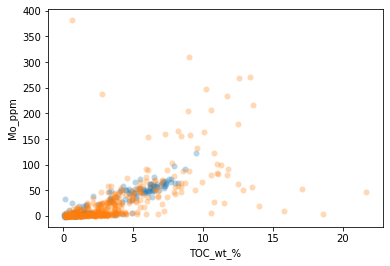

In [77]:
# Checking the loaded data:
display(training.head(10))
display(training.info())



# plot scatter plot of the training and test data

sns.scatterplot(x=training['TOC_wt_%'], y=training['Mo_ppm'],
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=training,alpha=0.3)

sns.scatterplot(x=testing['TOC_wt_%'], y=testing['Mo_ppm'],
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=testing,alpha=0.3)
plt.plot


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

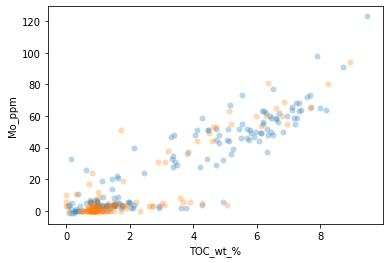

In [78]:
# compare the two datasets from the waco area

# print(french_only.info)

sns.scatterplot(x=training['TOC_wt_%'], y=training['Mo_ppm'],
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=training,alpha=0.3)

sns.scatterplot(x=french_cleaned['TOC_wt_%'], y=french_cleaned['Mo_ppm'],
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=french_cleaned,alpha=0.3)
plt.plot
